In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent word', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

In [ ]:
t = Tokenizer()
t.fit_on_texts(sentences) # 텍스트 -> 리스트
vocab_size = len(t.word_index) +1
print(vocab_size)

16


In [ ]:
print(t.word_index)

{'nice': 1, 'great': 2, 'best': 3, 'amazing': 4, 'stop': 5, 'lies': 6, 'pitiful': 7, 'nerd': 8, 'excellent': 9, 'word': 10, 'supreme': 11, 'quality': 12, 'bad': 13, 'highly': 14, 'respectable': 15}


In [ ]:
# text -> sequence
x_encoded = t.texts_to_sequences(sentences)
print(x_encoded)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [ ]:
# x_encoded의 최대값을 구하기
max_len = max(len(l) for l in x_encoded)
print(max_len)

4


In [ ]:
type(y_train)

list

In [ ]:
# x_train에 padding을 넣는다.
# y_train은 list였으나 numpy array로 변경해줘야 한다.
x_train = pad_sequences(x_encoded, maxlen= max_len, padding = 'post')
y_train = np.array(y_train)
print(type(y_train))
print(x_train)

<class 'numpy.ndarray'>
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

youngwoo = Sequential()
youngwoo.add(Embedding(vocab_size, 2, input_length=max_len)) # vocab_size * 2가 flatten으로 들어갈 것이다.
youngwoo.add(Flatten()) # Dense에 넣기 위해서 flatten으로 1차원 배열로 펴준다.
youngwoo.add(Dense(1, activation = 'sigmoid'))

youngwoo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 2)              32        
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [ ]:
youngwoo.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics=['acc'])
youngwoo.fit(x_train, y_train, epochs=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 698ms/step - loss: 0.6797 - acc: 0.7143
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6787 - acc: 0.7143
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6777 - acc: 0.7143
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6767 - acc: 0.7143
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6757 - acc: 0.7143
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6747 - acc: 0.7143
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6737 - acc: 0.7143
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6727 - acc: 0.7143
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6717 - acc: 0.7143
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6706 - acc: 0.7143
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6

# 네이버 영화 리뷰 감성 분석

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7fe23ec61ad0>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 58.1 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-24 01:31:06--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    return result

In [ ]:
def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): ##### 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. ##### 숫자 -> 텍스트
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

In [ ]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [ ]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 11s 11ms/step - loss: 0.4792 - accuracy: 0.7833 - val_loss: 0.3664 - val_accuracy: 0.8425
Epoch 2/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3349 - accuracy: 0.8602 - val_loss: 0.3486 - val_accuracy: 0.8490
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3029 - accuracy: 0.8751 - val_loss: 0.3502 - val_accuracy: 0.8484
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2811 - accuracy: 0.8853 - val_loss: 0.3573 - val_accuracy: 0.8482
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2587 - accuracy: 0.8950 - val_loss: 0.3605 - val_accuracy: 0.8491
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2363 - accuracy: 0.9052 - val_loss: 0.3723 - val_accuracy: 0.8508
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2145 - accuracy: 0.9139 - val_loss: 0.4015 - val_accuracy: 0.84

In [ ]:
# 테스트 셋으로 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.8837 - accuracy: 0.8162 - 4s/epoch - 3ms/step
[1.8837053775787354, 0.8162011504173279]


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

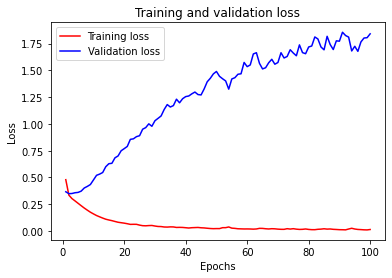

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

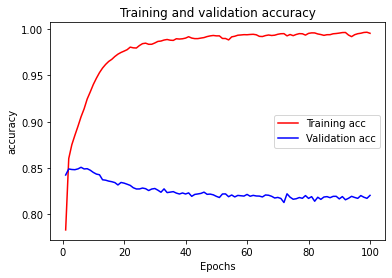

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 학습된 embedding layer 분석

In [ ]:
# gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path,'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 

vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([-0.17913222,  0.17764197,  0.11909441,  0.27415848,  0.09470374,
       -0.1783899 , -0.10008478, -0.23840363,  0.13467455,  0.14296295,
        0.15498239,  0.0192981 ,  0.1371074 , -0.10301857,  0.19572619,
       -0.03076334,  0.01855902,  0.05214974,  0.13177949, -0.09312768,
        0.21256204,  0.08589759, -0.00554439,  0.11419118,  0.2567497 ,
       -0.19412215,  0.24491668,  0.23772132, -0.12442359, -0.07861282,
       -0.13255641, -0.25075108,  0.27584198,  0.08862665, -0.12325258,
       -0.15098852, -0.1592104 , -0.20565997, -0.16806935,  0.00197919,
       -0.14291781, -0.104285  , -0.21682328, -0.16742377,  0.15843503,
       -0.16260989,  0.21105194, -0.24075912,  0.06491701, -0.11263127,
       -0.25164056,  0.07415479,  0.00376102, -0.18636888,  0.10753182,
        0.06302122, -0.05590043, -0.06897381,  0.07422142,  0.10122239,
       -0.22583053, -0.1094771 , -0.12051566, -0.24773966,  0.05833114,
       -0.03020309,  0.1233418 ,  0.2455236 ,  0.04244465,  0.11

In [ ]:
# 비슷한 단어 찾기 
word_vectors.similar_by_word('재미', topn=15)

[('최', 0.5863797068595886),
 ('95', 0.5601636171340942),
 ('출연진', 0.5429930686950684),
 ('내생', 0.5286546945571899),
 ('해외', 0.509926438331604),
 ('무게', 0.5080834627151489),
 ('찰리', 0.502543568611145),
 ('커리어', 0.5016152262687683),
 ('is', 0.5003294348716736),
 ('가져', 0.49764761328697205),
 ('순간', 0.49755701422691345),
 ('전후', 0.49225473403930664),
 ('오버랩', 0.4884284734725952),
 ('올랐', 0.4652520716190338),
 ('살렸', 0.4629759192466736)]

## 한국어 word2vec 임베딩 활용해 성능 개선

In [ ]:
import gensim

word2vec_path = '/content/drive/MyDrive/Colab Notebooks/영우_6기_자연어/수업안/dataset/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

# 감동에 대한 word의 vector값
vector = word2vec['감동']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [ ]:
word2vec.similar_by_word("로맨틱")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('코미디', 0.7576364278793335),
 ('로맨스', 0.7021660804748535),
 ('스릴러', 0.6693054437637329),
 ('개그', 0.6552960872650146),
 ('주제곡', 0.6495761871337891),
 ('뮤지컬', 0.6382305026054382),
 ('시트콤', 0.6167846322059631),
 ('서부극', 0.6151247620582581),
 ('연극과', 0.6083630323410034),
 ('서정적', 0.5965933799743652)]

In [ ]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 200 # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

model = keras.models.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer = Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                 input_length = maxlen,
                                 trainable = True)) # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 10s 11ms/step - loss: 0.5695 - accuracy: 0.6912 - val_loss: 0.4716 - val_accuracy: 0.7780
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4171 - accuracy: 0.8117 - val_loss: 0.3972 - val_accuracy: 0.8224
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3505 - accuracy: 0.8502 - val_loss: 0.3719 - val_accuracy: 0.8367
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3084 - accuracy: 0.8722 - val_loss: 0.3673 - val_accuracy: 0.8407
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2751 - accuracy: 0.8894 - val_loss: 0.3751 - val_accuracy: 0.8394
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2514 - accuracy: 0.9001 - val_loss: 0.3783 - val_accuracy: 0.8421
Epoch 7/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2234 - accuracy: 0.9137 - val_loss: 0.3955 - val_accuracy: 0.8394
Epoc

In [ ]:
result = model.evaluate(x_test, y_test, verbose=2)
print(result)

1537/1537 - 5s - loss: 0.8278 - accuracy: 0.8191 - 5s/epoch - 3ms/step
[0.8277592062950134, 0.8191102147102356]


# Proj. 기존 데이터에 word2vec적용해보기
- conv1D 모델
- lstm 모델
- 다른 embedding모델 적용해보기
- 결과 기록하기